In [1]:
import jVMC
import jax
#from jax.config import config
jax.config.update("jax_enable_x64", True)
import jax.random as jrnd
import jax.random as random

import jax.numpy as jnp
from functools import partial
import numpy as np
import jVMC.global_defs as global_defs
from tqdm import tqdm
import matplotlib.pyplot as plt
from flax import linen as nn
from typing import Any, List, Optional, Tuple
from jax import Array, vmap, jit
import math 
@jax.jit
def sorting_gumble(sample,logits,gumbel,states):
    indexes = jnp.argsort((-gumbel),axis=None)#.reshape(shape_gumbel)
    numSamples = sample.shape[0]
    ldim = sample.shape[1]
    L = sample.shape[2]
    #jax.debug.print("shape {x},{y},{z}",x=numSamples,y=ldim,z=L)
    indexes_states = (indexes // ldim)[:numSamples]
    sample = sample.reshape(-1,L)[indexes]
    sample = sample.reshape(ldim,numSamples,L)
    sample = jnp.swapaxes(sample,0,1)
    
    logits = logits.ravel()[indexes]
    logits = logits.reshape(ldim,numSamples).T
    
    gumbel = gumbel.ravel()[indexes]
    gumbel = gumbel.reshape(ldim,numSamples).T

    vals, treedef  = jax.tree_util.tree_flatten(states)
    vals_ordered = [v[indexes_states] for v in vals]
    states = jax.tree_util.tree_unflatten(treedef,vals_ordered)
    return sample,logits,gumbel,states

class gumbel_wrapper(nn.Module):
    """
    Wrapper module for symmetrization.
    This is a wrapper module for the incorporation of lattice symmetries. 
    The given plain ansatz :math:`\\psi_\\theta` is symmetrized as

        :math:`\\Psi_\\theta(s)=\\frac{1}{|\\mathcal S|}\\sum_{\\tau\\in\\mathcal S}\\psi_\\theta(\\tau(s))`

    where :math:`\\mathcal S` denotes the set of symmetry operations (``orbit`` in our nomenclature).

    Initialization arguments:
        * ``orbit``: orbits which define the symmetry operations (instance of ``util.symmetries.LatticeSymmetry``)
        * ``net``: Flax module defining the plain ansatz.
        * ``avgFun``: Different choices for the details of averaging.

    """
    #orbit: LatticeSymmetry
    net: callable
    is_gumbel = True

    #avgFun: callable = avgFun_Coefficients_Exp
    def __setup__(self):
        self.L = self.net.L

    def __post_init__(self):

        super().__post_init__()
        #self.orbit = None
        #self.is_generator = self.net.is_generator
    """
    def __call__(self, x):

        inShape = x.shape
        x = 2 * x - 1
        x = jax.vmap(lambda o, s: jnp.dot(o, s.ravel()).reshape(inShape), in_axes=(0, None))(self.orbit.orbit, x)
        x = (x + 1) // 2

        def evaluate(x):
            return self.net(x)

        res = jax.vmap(evaluate)(x)
        return self.avgFun(res, self.orbit.factor)
    """
    
    def __call__(self,*args,**kwargs):
        
        #def evaluate(x):
        #    return self.net(x)

        #res = jax.vmap(evaluate)(x)
        return self.net(*args,**kwargs)
        
    def _apply_fun(self, *args,**kwargs):
        return self.net.apply(*args,**kwargs)

# ** end class SymNet
        #return sample,logits,gumbel,states
    
    
    def _gumbel_step(self,sample,logits,gumbel,key,states,position):        
        particles_left = self.net.Q - jnp.sum(sample[0]+jnp.abs(sample[0]))//2
        #new samples with (0,..,ldim-1) at position
        sample = jnp.array([sample[0].at[position].set(l) for l in jnp.arange(self.net.ldim)])
        #right shifted input
        inputt = jnp.array([jnp.pad(sample[0,:-1],(1,0))])
        logitnew, next_states = self(inputt[:,position],block_states = states, output_state=True)
        #logitnew, next_states = self.net.net(inputt[:,position],block_states = states, output_state=True)
    
        #jax.debug.print("pl: {x}",x=particles_left)
        must_give = jax.nn.relu(particles_left-self.net.max_particles[position])

        # number of particles that can be assigned
        can_give = jnp.minimum(particles_left, self.net.ldim-1)
        mask = (self.net.must_mask[must_give] + 
                    self.net.can_mask[can_give.astype(int)]) 
        #logit_renorm =  logitnew - mask ** jnp.inf
        #jax.debug.print("mask {x}", x=mask)
        logitnew =  jax.nn.log_softmax(logitnew - mask ** jnp.inf)
        #jax.debug.print("logits new {x}", x=logitnew)
        #jax.debug.print("logits[0] {x}", x=logits[0])
        
        logitnew = logits[0] + logitnew - mask ** jnp.inf
        #jax.debug.print("logits new {x}", x=logitnew)

        gumbelnew = logitnew + jrnd.gumbel(key[0],shape=(self.net.ldim,))  ## logitnew or logits[0]?
        #gumbelnew = logits[0] + jrnd.gumbel(key[0],shape=(ldim,))
        #jax.debug.print("gumbelnew new {x}", x=gumbelnew)

        Z = jnp.nanmax(gumbelnew)
        gumbelnew = jnp.nan_to_num(-jnp.log(
            jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(-gumbelnew) # -sign at gumbelnew??
            ),nan=-jnp.inf)
        #gumbelnew = (-jnp.log(jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(gumbelnew)))
        gumbelnew = gumbelnew- mask ** jnp.inf
        return sample, logitnew, gumbelnew, next_states
    def sample(self, numSamples: int, key) -> Array:
        """Autoregressively sample a spin configuration.

        Args:
            * ``numSamples``: The number of configurations to generate.
            * ``key``: JAX random key.

        Returns:
            A batch of spin configurations.
        """
        
        """
        def generate_sample(key):
            key = jrnd.split(key, self.net.L)
            logits, carry = self(jnp.zeros(1,dtype=int),block_states = None, output_state=True)

            choice = jrnd.categorical(key[0], logits.ravel()) # abide by the indexing convention and apply -1
            s_cumsum = self.net.Q - choice # create cumsum of the quantum number
            _, s = self._scanning_fn((jnp.expand_dims(choice,0),carry,s_cumsum),(key[1:],jnp.arange(1,self.net.L)))
            return jnp.concatenate([jnp.expand_dims(choice,0),s])
        """
        # get the samples
        keys = jrnd.split(key, (self.net.L))
        ## init stap
        shape_samples = (numSamples,self.net.ldim,self.net.L)
        shape_logits = (numSamples,self.net.ldim)
        shape_gumbel = (numSamples,self.net.ldim)
        #print(shape_samples,shape_logits)
        working_space_samples = jnp.full(shape_samples,-2,dtype=jnp.int64)
        working_space_logits = jnp.full(shape_logits,-jnp.inf,dtype=jnp.float64)
        working_space_gumbel = jnp.full(shape_gumbel,-jnp.inf,dtype=jnp.float64)
        
        working_space_samples = working_space_samples.at[0,0,0].set(0)
        working_space_logits = working_space_logits.at[0,0].set(0.)
        working_space_gumbel = working_space_gumbel.at[0,0].set(0.)
        
        states = None
        init_work = partial(self._gumbel_step, position=0,states=states)
        key0=jrnd.split(keys[0],(numSamples,1))
        
        sample,logits,gumbel,states  = jax.vmap(init_work)(working_space_samples,working_space_logits,working_space_gumbel,key0)
        
        init_carry = sorting_gumble(sample,logits,gumbel,states)
        
        res,_ = self._scanning_fn(init_carry,(keys[1:],jnp.arange(1,self.net.L)))
        samples, logits,gumbels,_ = res
        
        kappa = gumbels[0,1]
        #jax.debug.print("kappa {x}", x=kappa)
        
        re_weights = jnp.nan_to_num(jnp.exp(logits[:,0]) /(-jnp.expm1(-jnp.exp(logits[:,0]-kappa))),0)
        #jax.debug.print("re {x}", x=re_weights)


        # return to the spinless representation
        return samples[:,0,:],logits[:,0]*self.net.logProbFactor,re_weights/jnp.sum(re_weights)

    @partial(nn.scan,
             variable_broadcast='params',
             split_rngs={'params': False})
    def _scanning_fn(self, carry, key):
        position = key[1]
        sample = carry[0]
        #jax.debug.print("{x}", x=sample)

        logits = carry[1]
        gumbel = carry[2]
        states = carry[3]
        keys = jrnd.split(key[0],(carry[0].shape[0],1))

        p_workN = partial(self._gumbel_step,position=position)
        sample,logits,gumbel,states = jax.vmap(p_workN)(sample,logits,gumbel,keys,states)
        #jax.debug.print("gumbelnew new {x}", x=gumbel)

        #### sorting gumble value
        return sorting_gumble(sample,logits,gumbel,states),None
        """
        logits, next_states = self(carry[0],block_states = carry[1], output_state=True)
        #jax.debug.print("logits {x}\n carry {y}",x=logits,y=carry)

        ##############################################
        # mask logits
        # number of particles that mus assigned
        must_give = nn.relu(carry[2]-self.net.max_particles[key[1]])
        # number of particles that can be assigned
        can_give = jnp.minimum(carry[2], self.net.LocalHilDim-1)
        # compute mask
        mask = (self.net.must_mask[must_give] + 
                    self.net.can_mask[can_give.astype(int)]) 
        ##############################################
        logits = logits - mask ** jnp.inf
        choice = jrnd.categorical(key[0], logits.ravel().real) # abide by the indexing convention
        ##############################################
        s_cumsum = carry[2] - choice
        return (jnp.expand_dims(choice,0), next_states, s_cumsum), choice
        """

In [2]:
N = 5
L = 5
ldim = 6
homFock = jnp.ones((1,1,L),dtype=int)
J = 1.
U = 0.

H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U,lDim=ldim)
print(homFock)
emb_RWKV = 2

depth_RWKV = 2

math.comb(N+L-1,L-1),2**7

[[[1 1 1 1 1]]]


(126, 128)

In [3]:
net_RWKV = jVMC.nets.bosons.GPT(L,N,ldim,emb_RWKV,depth_RWKV,1)
#jVMC.nets.bosons.RWKV(L,N,LocalHilDim=ldim,num_layers=depth_RWKV,embedding_size=emb_RWKV)
net_RWKV_gumbel = jVMC.nets.bosons.RWKV(L,N,LocalHilDim=ldim,num_layers=depth_RWKV,embedding_size=emb_RWKV)
gumbel_net = gumbel_wrapper(net_RWKV_gumbel)

sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
symNet = jVMC.nets.sym_wrapper.SymNet(sym,net_RWKV,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)



In [4]:
#psi_RWKV = jVMC.vqs.NQS(symNet)
psi_RWKV = jVMC.vqs.NQS(net_RWKV,seed=1)
psi_RWKV2 = jVMC.vqs.NQS(net_RWKV,seed=2)

psi_RWKV_gumbel = jVMC.vqs.NQS(gumbel_net)
psi_RWKV_gumbel2 = jVMC.vqs.NQS(gumbel_net,seed=3)

psi_RWKV(homFock),psi_RWKV2(homFock),psi_RWKV_gumbel(homFock),psi_RWKV_gumbel2(homFock)

(Array([[-14.03102548]], dtype=float64),
 Array([[-2.51970033]], dtype=float64),
 Array([[-3.1723223]], dtype=float64),
 Array([[-3.13161079]], dtype=float64))

In [5]:
psi_RWKV_gumbel2.params

FrozenDict({
    net: {
        Head: {
            kernel: Array([[ 1.0154816 ,  0.17952294,  0.2267414 ,  0.3799486 , -0.49012803,
                     0.60330309],
                   [ 0.40799065,  0.22531432, -1.04876188, -0.4378422 ,  0.47293275,
                     0.2378718 ]], dtype=float64),
        },
        Neck: {
            bias: Array([0., 0.], dtype=float64),
            kernel: Array([[ 0.94613058,  0.44577977],
                   [-0.64393637,  0.16243347]], dtype=float64),
        },
        blocks_0: {
            channel_mix: {
                KeyP: {
                    kernel: Array([[ 1.23843174,  0.20285499,  0.55251719, -0.36271778, -0.59733475,
                            -0.33441459, -1.31711468,  0.39988972],
                           [ 0.67451605,  0.86141423,  1.49321239, -1.20179223, -0.52528335,
                             0.66214472, -0.85800642, -0.14736063]], dtype=float64),
                },
                ReceptanceP: {
                    ke

In [6]:
psi_RWKV_gumbel.is_gumbel,psi_RWKV.is_gumbel



(True, False)

In [7]:
key = jrnd.PRNGKey(1)
key2 = jrnd.PRNGKey(1)

sampler = jVMC.sampler.MCSampler(psi_RWKV,(L,),key)
sampler_gumbel = jVMC.sampler.MCSampler(psi_RWKV_gumbel,(L,),key2)

lr_SR = 1e-2
minSR_equation = jVMC.util.MinSR(sampler, makeReal='real',diagonalShift=1e-2)#,diagonalMulti=1e-3)
minSR_equation_gumbel = jVMC.util.MinSR(sampler_gumbel, makeReal='real',diagonalShift=1e-2)#,diagonalMulti=1e-3)

stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  
    

In [8]:
#%timeit sampler_gumbel.sample(numSamples=2**6)
#%timeit sampler.sample(numSamples=2**6)
sampler.sample(numSamples=2**6)


(Array([[[0, 3, 0, 2, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 0, 1, 0, 1],
         [2, 3, 0, 0, 0],
         [3, 0, 2, 0, 0],
         [3, 1, 0, 0, 1],
         [3, 1, 0, 0, 1],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [5, 0, 0, 0, 0],
         [3, 1, 0, 0, 1],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [4, 0, 0, 0, 1],
         [3, 0, 2, 0, 0],
         [3, 1, 0, 0, 1],
         [4, 0, 1, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 0, 2, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [4, 0, 0, 0, 1],
         [4, 0, 0, 0, 1],
         [3, 2, 0, 0, 0],
         [4, 0, 1, 0, 0],
         [3, 0, 2, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [4, 0, 1, 0, 0],
         [4, 0, 0, 0, 1],
         [3, 2, 0, 0, 0],
         [2, 3, 0, 0, 0],
         [4, 0, 0, 0, 1],
         [3,

In [9]:
training_steps= 500
resTraining = np.zeros((training_steps,2))
resTraining_gumbel = np.zeros((training_steps,2))

numS = 2**6
pbar = tqdm(range(training_steps))
for n,p in enumerate(pbar):
    dpOld = psi_RWKV.get_parameters()        
    #print(dpOld.shape)
    dp, _ = stepperSR.step(0, minSR_equation, dpOld, hamiltonian=H, psi=psi_RWKV, numSamples=numS)
    psi_RWKV.set_parameters(jnp.real(dp))
    resTraining[n] = [jnp.real(minSR_equation.ElocMean0) , minSR_equation.ElocVar0 ]
    
    dpOld = psi_RWKV_gumbel.get_parameters()                
    dp, _ = stepperSR.step(0, minSR_equation_gumbel, dpOld, hamiltonian=H, psi=psi_RWKV_gumbel, numSamples=numS)
    psi_RWKV_gumbel.set_parameters(jnp.real(dp))
    resTraining_gumbel[n] = [jnp.real(minSR_equation_gumbel.ElocMean0) , minSR_equation_gumbel.ElocVar0 ]
    
    pbar.set_description(f"energy: {resTraining[n][0]:.2f}+-{np.sqrt(resTraining[n][1]):.4f} __ gumbel "+f"energy: {resTraining_gumbel[n][0]:.2f}+-{np.sqrt(resTraining_gumbel[n][1]):.2f}")

energy: -4.12+-4.1188 __ gumbel energy: -8.47+-8.52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:59<00:00,  4.17it/s]


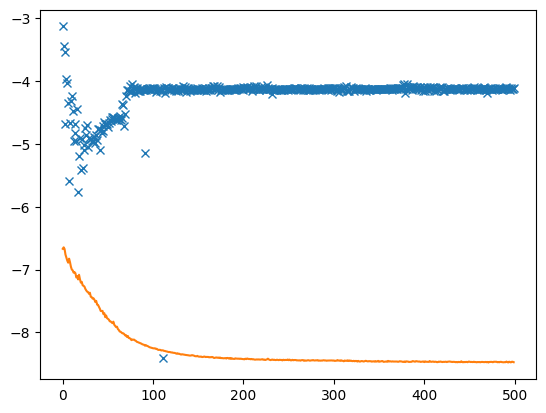

In [10]:
plt.plot(resTraining[:,0],'x')
plt.plot(resTraining_gumbel[:,0])
#plt.ylim(-10,10)

[]

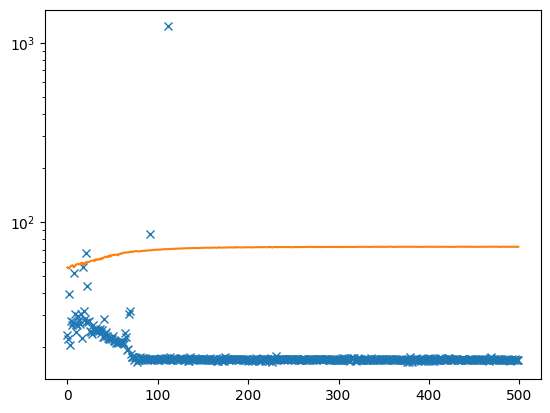

In [11]:
plt.plot(resTraining[:,1],'x')
plt.plot(resTraining_gumbel[:,1])
#plt.ylim(-10,10)
plt.semilogy()

In [12]:
sampler.sample(numSamples=16)

(Array([[[3, 2, 0, 0, 0],
         [2, 3, 0, 0, 0],
         [4, 1, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [2, 3, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [2, 3, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [2, 3, 0, 0, 0],
         [4, 1, 0, 0, 0],
         [4, 1, 0, 0, 0],
         [3, 2, 0, 0, 0],
         [3, 2, 0, 0, 0]]], dtype=int64),
 Array([[-0.36165003, -0.63499804, -0.72619239, -0.36165003, -0.36165003,
         -0.63499804, -0.36165003, -0.63499804, -0.36165003, -0.36165003,
         -0.36165003, -0.63499804, -0.72619239, -0.72619239, -0.36165003,
         -0.36165003]], dtype=float64),
 Array([[0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]],      dtype=float64))

In [13]:
sampler_gumbel.sample(numSamples=16)

(Array([[[1, 2, 1, 1, 0],
         [2, 3, 0, 0, 0],
         [4, 1, 0, 0, 0],
         [1, 2, 1, 0, 1],
         [3, 1, 1, 0, 0],
         [3, 2, 0, 0, 0],
         [2, 2, 0, 0, 1],
         [2, 1, 0, 0, 2],
         [3, 0, 0, 1, 1],
         [2, 2, 1, 0, 0],
         [2, 1, 1, 1, 0],
         [1, 2, 0, 2, 0],
         [4, 0, 0, 1, 0],
         [3, 1, 0, 0, 1],
         [2, 1, 0, 2, 0],
         [0, 3, 1, 1, 0]]], dtype=int64),
 Array([[-1.58761879, -1.45485378, -1.95973184, -1.51739892, -1.61464183,
         -1.61051167, -1.57295129, -2.04602608, -2.68080131, -1.35258884,
         -1.60259304, -2.2746053 , -2.58100576, -1.82699067, -2.05081168,
         -2.29276343]], dtype=float64),
 Array([[0.08624436, 0.11247317, 0.04097485, 0.09924826, 0.08170691,
         0.08238463, 0.08881181, 0.03447968, 0.00968734, 0.13799874,
         0.08369976, 0.02182839, 0.0118273 , 0.05343366, 0.03415124,
         0.02104989]], dtype=float64))

In [14]:
net_g = gumbel_sampler(net_RWKV_gumbel)
psi_g = jVMC.vqs.NQS(net_g)

NameError: name 'gumbel_sampler' is not defined

In [ ]:
sampler_new = jVMC.sampler.MCSampler(psi_g,(L,),12,jrnd.PRNGKey(1))

In [ ]:
%timeit sampler_new.sample(numSamples=1024)

In [ ]:
s,l,p = sampler_new.sample(numSamples=129)


In [ ]:
jnp.exp(2*l)-p

In [ ]:
def jonasFunction(self,x,*args):
    return self(x,block_states=None,output_state=False)

In [ ]:
psi_RWKV.net.apply(psi_RWKV.parameters,homFock,method=jonasFunction) 

In [ ]:
import math
math.comb(N+L-1,L-1)

In [ ]:
jnp.exp(-jnp.inf)